# **Automate Identification And Recognition Of Handwritten Text from An Image.**
 (Using Convolutional Recurrent Neural Network)



---



---


**Name Of The Student		:**	C A Gnanesh Kumar 

**Internship Project Topic		:** Automate identification and recognition of handwritten text from an image

**Name of the Organization	:** TCS iON

**Name of the Industry Mentor	:** Debahsis roy

**Name of the Institute		:** Sri Venkateswara University College of Engineering 


---



---




## **Setting Up Kaggle in Google Colab.**
This is optional method to run this model. This method is only for use of GPU on Google Colab. If one wants to use GPU on local machine then this step is not required. I used kaggle to load dataset in Google Colab. There are 4 steps to setting up kaggle in google colab.

1.   Install Kaggle.
2.   Create token.
3.   Create Folder.
4.   Get API link and download dataset.
5.   Unzip the File.

## **Dataset**
we used IAM handwritten datset. This is good dataset total of 1.09 GB images. Here I have used only 7850 images for the training set and 876 images for validation dataset.

To download the dataset either you can directly download from [this link](https://fki.tic.heia-fr.ch/databases/download-the-iam-handwriting-database) or use the following commands to download the data and unzip.




**Installing Kaggle to use kaggle dataset on Google Colab.**

In [ ]:
!pip install kaggle

**First grab your token from kaggle.**

For more details of creating API on kaggle [click here](https://towardsdatascience.com/setting-up-kaggle-in-google-colab-ebb281b61463).

Upload the json file got from kaggle.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saignanesh","key":"37e4f1622cdad52accf44f28b374d6eb"}'}

**Create a folder to store kaggle dataset on colab.**

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json


**Copy the API link and paste with '!' to download the datset.**

# New section

In [ ]:
!kaggle datasets download -d saithejacharymuthoju/iamword

100% 1.09G/1.10G [00:06<00:00, 199MB/s]
100% 1.10G/1.10G [00:06<00:00, 188MB/s]


**This code for unzip the file.**

In [ ]:
from zipfile import ZipFile
filename="iamword.zip"
with ZipFile(filename,"r") as zip:
  zip.extractall()
  print("done")

done


## **Importing necessary packages.**

**Installing Keras_tqdm.**

In [ ]:
!pip install keras_tqdm

In [ ]:
pip install keras.utils

  Created wheel for keras.utils: filename=keras_utils-1.0.13-cp37-none-any.whl size=2657 sha256=883d3c0e002063f6d4420f6f126e6a8934c9355d73e96b854972cab3b2102eb4
  Stored in directory: /root/.cache/pip/wheels/46/25/27/7707005c1cb27e1ffc8277b004ac295e34767b02b44d73d6be
Successfully built keras.utils


In [ ]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt

import os
from google.colab import drive #To use googel drive to get files.

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional,Dropout
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
#from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## **Tensorflow GPU**

We used Google Colab GPU.

In [ ]:
from tensorflow.python.client import device_lib

# Check all available devices if GPU is available
print(device_lib.list_local_devices())
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16122478460801048560
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14509932544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1024595653599271579
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



**This step is to check GPU is available or not.**

In [ ]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

## **Preprocessing**
Now we are having our dataset, to make it acceptable for our model we need to use some preprocessing. We need to preprocess both the input image and output labels. 
To preprocess our input image we will use followings:
Read the image and convert into a gray-scale image
Make each image of size (128,32) by using padding
Expand image dimension as (128,32,1) to make it compatible with the input shape of architecture
Normalize the image pixel values by dividing it with 255.

To preprocess the output labels use the followings:
Read the text from the words.txt file because it contains text written inside the image. Which is in the format 'a01-000u-00-00 ok 154 408 768 27 51 AT A'.

Compute the maximum length from words and pad every output label to make it of the same size as the maximum length. This is done to make it compatible with the output shape of our RNN architecture. Then convert to numpy array.

1.   Dataset = [IAM dataset.](http://www.fki.inf.unibe.ch/databases/iam-handwriting-database/download-the-iam-handwriting-*database*)
2.   Dataset used in this project = [words.tgz](http://www.fki.inf.unibe.ch/DBs/iamDB/data/words/)





**Loading words.txt file in this function.**

In [ ]:
drive.mount("/content/gdrive")
with open("gdrive/My Drive/tcs ion project/words.txt") as f:
  contents=f.readlines()
lines=[line.strip() for line in contents]
lines[0]


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'a01-000u-00-00 ok 154 408 768 27 51 AT A'

In [ ]:
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" 

# string.ascii_letters + string.digits (Chars & Digits)
# or 
# "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))
        
    return dig_lst

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [ ]:
images = []
labels = []

RECORDS_COUNT = 10000

In [ ]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

In [ ]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape
    
#     _, img = cv2.threshold(img, 
#                            128, 
#                            255, 
#                            cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    
    img = img.astype('float32')
    
    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
        
    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)
    
    img = np.expand_dims(img, axis=2)
    
    # Normalize 
    img = img / 255
    
    return img

**Generate Train and Validation set.**

*Here we are 
using kaggle dataset.
Which is unziped file of words.tgz*

In [ ]:
for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]
    
    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])
        
        splits_id = word_id.split('-')
        filepath = 'words/{}/{}-{}/{}.png'.format(splits_id[0], 
                                                  splits_id[0], 
                                                  splits_id[1], 
                                                  word_id)
        
        # processing on image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue
            
        # processing on label
        try:
            label = encode_to_labels(word)
        except:
            continue
        
        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)
        
        if len(word) > max_label_len:
            max_label_len = len(word)
    
    if index >= RECORDS_COUNT:
        break

**Generate Padded label**
(padded_label = pad_sequences(labels, 
                              maxlen=max_label_len, 
                              padding='post',
                              value=len(char_list)))

In [ ]:
train_padded_label = pad_sequences(train_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

In [ ]:
train_padded_label.shape, valid_padded_label.shape

((7850, 16), (876, 16))

**Convert to numpy array.**
*   images = np.asarray(images)
*   inputs_length = np.asarray(inputs_length)
*   labels_length = np.asarray(labels_length)

In [ ]:

train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [ ]:
train_images.shape

(7850, 32, 128, 1)

## **Build Model (Network Architecture).**
(Using Convolutional Recurrent Neural Network)

This network architecture is inspired by [this paper](https://arxiv.org/pdf/1507.05717.pdf). Let’s see the steps that we used to create the architecture:

Input shape for our architecture having an input image of height 32 and width 128.
Here we used seven convolution layers of which 6 are having kernel size (3,3) and the last one is of size (2.2). And the number of filters is increased from 64 to 512 layer by layer.
Two max-pooling layers are added with size (2,2) and then two max-pooling layers of size (2,1) are added to extract features with a larger width to predict long texts.
Also, we used batch normalization layers after fifth and sixth convolution layers which accelerates the training process.
Then we used a lambda function to squeeze the output from conv layer and make it compatible with LSTM layer.
Then used two Bidirectional LSTM layers each of which has 128 units. This RNN layer gives the output of size (batch_size, 31, 63). Where 63 is the total number of output classes including blank character.

In [ ]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
conv_5= Conv2D(256, (3,3), activation="relu", padding="same")(conv_4)

# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)

# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_6)
 
conv_7 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_7)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_8 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_8)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [ ]:
act_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 128, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 128, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 32, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 32, 256)        295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 32, 256)        590080

## **Loss Function**
Here, we are using the CTC loss function. CTC loss is very helpful in text recognition problems. It helps us to prevent annotating each time step and help us to get rid of the problem where a single character can span multiple time step which needs further processing if we do not use CTC. 

A CTC loss function requires four arguments to compute the loss, predicted outputs, ground truth labels, input sequence length to LSTM and ground truth label length. To get this we need to create a custom loss function and then pass it to the model. To make it compatible with our model, we will create a model which takes these four inputs and outputs the loss. This model will be used for training and for testing we will use the model that we have created earlier “act_model”. Let’s see the code:

In [ ]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])
print(loss_out[:5])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='tf.__operators__.getitem/strided_slice:0', description="created by layer 'tf.__operators__.getitem'")


## **Train the Model**
To train the model we will use Adam optimizer. Also, we can use Keras callbacks functionality to save the weights of the best model on the basis of validation loss. In model.compile(), you can see that I have only taken y_pred and neglected y_true. This is because I have already taken labels as input to the model earlier. labels as input to the model earlier.

Now train your model on 7850 training images and 876 validation images.

In [ ]:
batch_size = 8
epochs = 30
e = str(epochs)
optimizer_name = 'sgd'

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath="gdrive/My Drive/tcs ion project/{}o-{}r-{}e-{}t-{}v.hdf5".format(optimizer_name,
                                          str(RECORDS_COUNT),
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=2,
                    callbacks=callbacks_list)

Epoch 1/30
982/982 - 96s - loss: 15.6675 - accuracy: 0.0000e+00 - val_loss: 14.8594 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 14.85940, saving model to gdrive/My Drive/tcs ion project/sgdo-10000r-30e-7850t-876v.hdf5
Epoch 2/30
982/982 - 29s - loss: 13.3572 - accuracy: 0.0015 - val_loss: 19.1932 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss did not improve from 14.85940
Epoch 3/30
982/982 - 29s - loss: 11.7732 - accuracy: 0.0208 - val_loss: 15.0920 - val_accuracy: 0.0240

Epoch 00003: val_loss did not improve from 14.85940
Epoch 4/30
982/982 - 28s - loss: 10.3514 - accuracy: 0.0599 - val_loss: 12.1686 - val_accuracy: 0.0491

Epoch 00004: val_loss improved from 14.85940 to 12.16859, saving model to gdrive/My Drive/tcs ion project/sgdo-10000r-30e-7850t-876v.hdf5
Epoch 5/30
982/982 - 29s - loss: 8.7627 - accuracy: 0.1127 - val_loss: 13.9794 - val_accuracy: 0.0468

Epoch 00005: val_loss did not improve from 12.16859
Epoch 6/30
982/982 - 29s - loss: 7.0887 - 

## **Test the Model**
Our model is now trained with 7850 images. Now its time to test the model. We can not use our training model because it also requires labels as input and at test time we can not have labels. So to test the model we will use ” act_model ” that we have created earlier which takes only one input: test images.

As our model predicts the probability for each class at each time step, we need to use some transcription function to convert it into actual texts. Here we used the CTC decoder to get the output text. Let’s see the code:

We use Jaro Distance & Ratio method to test accuracy.

**Installing Levenshtein package in google colab.** 

In [ ]:
  !pip install python-levenshtein

     |████████████████████████████████| 51kB 6.2MB/s 
  Created wheel for python-levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149809 sha256=abb9399c7d52211cc5a8e5630e0dd01421692115a1457ae60b0237427bed1a96
  Stored in directory: /root/.cache/pip/wheels/b3/26/73/4b48503bac73f01cf18e52cd250947049a7f339e940c5df8fc
Successfully built python-levenshtein


In [ ]:
# load the saved best model weights
act_model.load_weights(filepath)

# predict outputs on validation images
prediction = act_model.predict(valid_images)
 
# use CTC decoder
decoded = K.ctc_decode(prediction, 
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]
out = K.get_value(decoded)

import Levenshtein as lv

total_jaro = 0
total_rati = 0
# see the results
for i, x in enumerate(out):
    letters=''
    for p in x:
        if int(p) != -1:
            letters+=char_list[int(p)]
    total_jaro+=lv.jaro(letters, valid_original_text[i])
    total_rati+=lv.ratio(letters, valid_original_text[i])

print('jaro :', total_jaro/len(out))
print('ratio:', total_rati/len(out))

jaro : 0.9277729827672756
ratio: 0.9019569951438459


**Prediction.**

original_text =   13
predicted text = 1s

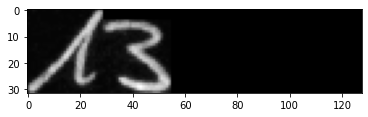



original_text =   Most
predicted text = Most

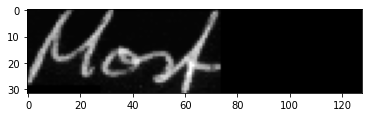



original_text =   the
predicted text = the

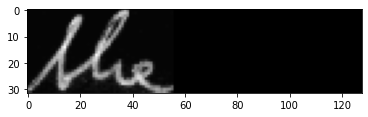



original_text =   has
predicted text = has

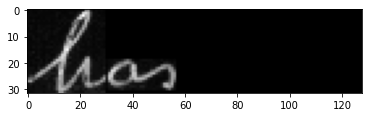



original_text =   two
predicted text = tuo

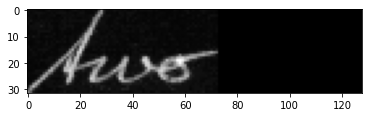



original_text =   to
predicted text = to

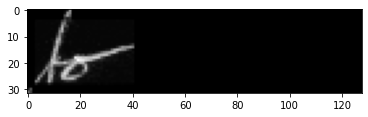



original_text =   Welensky
predicted text = Welensky

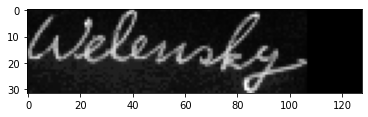



original_text =   Labour
predicted text = Labour

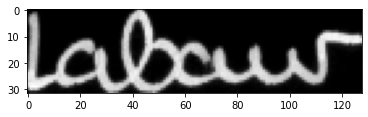



original_text =   Labour
predicted text = Labour

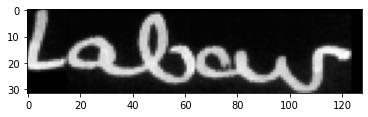



original_text =   of
predicted text = of

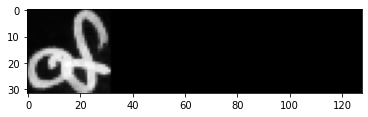



original_text =   have
predicted text = have

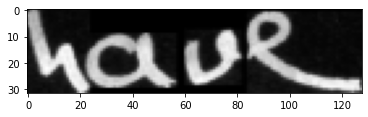



original_text =   African
predicted text = African

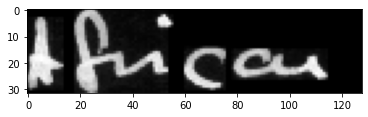



original_text =   together
predicted text = together

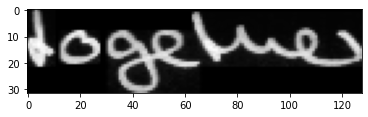



original_text =   the
predicted text = the

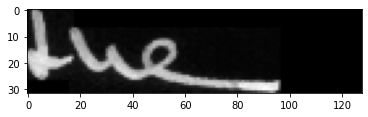



original_text =   Peers
predicted text = Peers

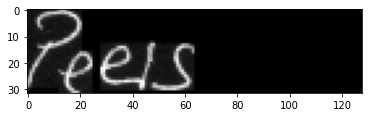



original_text =   sentiment
predicted text = sentiment

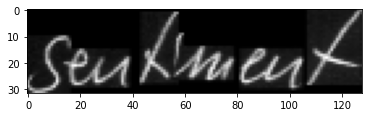



original_text =   Lords
predicted text = Lords

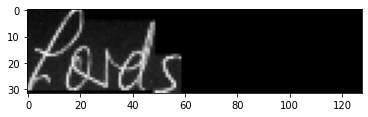



original_text =   an
predicted text = an

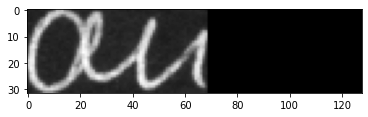



original_text =   Nationalist
predicted text = Nationalist

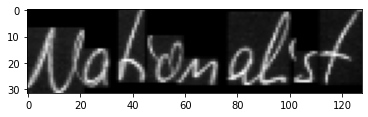



original_text =   to
predicted text = to

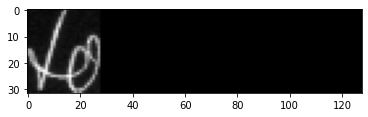

In [ ]:
# predict outputs on validation images
prediction =act_model.predict(valid_images[30:50])
 
# use CTC decoder
decoded = K.ctc_decode(prediction,   
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

# see the results
for i, x in enumerate(out):
    print("original_text =  ", valid_original_text[30+i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(valid_images[30+i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    print('\n')

## **Plot Accuracy and Loss**

In [ ]:
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

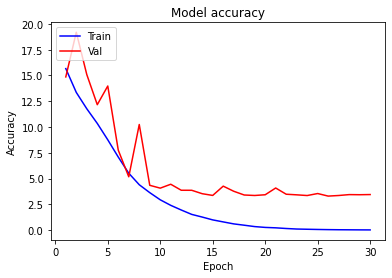

In [ ]:
plotgraph(epochs, loss, val_loss)

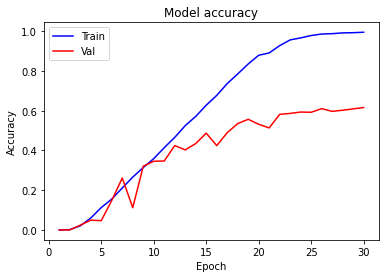

In [ ]:
plotgraph(epochs, acc, val_acc)

## **Get Best Model Index**

In [ ]:
minimum_val_loss = np.min(history.history['val_loss'])
best_model_index = np.where(history.history['val_loss'] == minimum_val_loss)[0][0]

best_loss = str(history.history['loss'][best_model_index])
best_acc = str(history.history['accuracy'][best_model_index])
best_val_loss = str(history.history['val_loss'][best_model_index])
best_val_acc = str(history.history['val_accuracy'][best_model_index])

In [ ]:
with open('gdrive/My Drive/tcs ion project/history.txt', 'a') as f:
    new_data = '{},{},{},{},{},{},{},{},{},{}\n'.format(filepath, 
                                                      optimizer_name, 
                                                      str(RECORDS_COUNT), 
                                                      e, 
                                                      str(train_images.shape[0]),
                                                      str(valid_images.shape[0]), 
                                                      best_loss, 
                                                      best_acc, 
                                                      best_val_loss, 
                                                      best_val_acc)
    f.write(new_data)

## **Save the Model.**

In [ ]:
model.save('gdrive/My Drive/tcs ion project/Text_recognizer_Using_CRNN.h5')